In [2]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import tensorboard as tb
from tensorboard.backend.event_processing import event_accumulator
from random import choices
from itertools import combinations

In [3]:
def age_debiasing(predicted_ages, chronological_ages):
    
    predicted_ages = predicted_ages.to_numpy()
    chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

def age_debiasing(predicted_ages, chronological_ages):
    
    predicted_ages = predicted_ages.to_numpy()
    chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

def tensorboard_reader(directory, tag='AgeDelta/epoch'):
    """
    Sources: 
    https://stackoverflow.com/questions/41074688/how-do-you-read-tensorboard-files-programmatically
    https://stackoverflow.com/questions/37304461/tensorflow-importing-data-from-a-tensorboard-tfevent-file
    """
    
    for dataset in ['train', 'validation']:
    
        dct = {}
        steps = []
        values = []
    
        if dataset == 'train':
            dir_name = directory + '/train/'
        else:
            dir_name = directory + '/validation/'

        list_of_files = os.listdir(dir_name)

        for file in list_of_files:
            file_name=dir_name+file
#             print(file_name)
            ea = event_accumulator.EventAccumulator(file_name,
              size_guidance={
              event_accumulator.COMPRESSED_HISTOGRAMS: 500,
              event_accumulator.IMAGES: 4,
              event_accumulator.AUDIO: 4,
              event_accumulator.SCALARS: 0,
              event_accumulator.HISTOGRAMS: 1,
          })
            ea.Reload()
#             print(ea.Tags())
            if tag in ea.Tags()['scalars']:
                for e in ea.Scalars(tag):
                    step = e.step
                    value = e.value
                    steps.append(step)
                    values.append(value)

        dct['step'] = steps
        
        if dataset == 'train':
            dct['train'] = values
            dfp = pd.DataFrame.from_dict(dct)
        else:
            dct['validation'] = values
            dfv = pd.DataFrame.from_dict(dct)

    df = pd.merge(dfp, dfv, how='left', on='step')
    df = df.sort_values('step')
    
    return df

def linear_plotter(x, y_train, y_validation, xlabel, ylabel, title, ylim_flag=False, xlim=None):
    
    if isinstance(x, np.ndarray):
        pass
    else:
        x = x.values
        y_train = y_train.values
        y_validation = y_validation.values
    
    plt.figure(figsize=[14.4,7.2])
    plt.plot(x, y_train, label='Train')
    plt.plot(x, y_validation, label='Validation')
    plt.xlabel(xlabel)
    if ylim_flag == True:
        ylim_min = -0.25
        ylim_max = np.max(y_train) + 5
        plt.ylim((ylim_min, ylim_max))
    best_validation = np.min(y_validation)
    best_epoch = x[np.where(y_validation == np.min(y_validation))[0][0]]
    best_train = y_train[np.where(y_validation == np.min(y_validation))[0][0]]
    gap = best_train - best_validation
    print(best_epoch, best_validation)
    print(-gap)
    plt.scatter(x=best_epoch, y=best_validation, s=100, marker='*', color='red', label='Selected Best Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()
    
def linear_plotter_comparison(Xs, Ys, Labels,
                              xlabel, ylabel, title, ylim_flag=False):
    
    plt.figure(figsize=[7,5])
    for idx, x in enumerate(Xs):
        plt.plot(x, Ys[idx], label=Labels[idx])
    plt.xlabel(xlabel)
    if ylim_flag == True:
        ylim_min = -0.25
        y_max = [np.max(Ys[idx]) for idx in range(len(Ys))]
        ylim_max = min(y_max)
        plt.ylim((ylim_min, ylim_max))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_everything(network='49', ylim2=[2.175, 2.45], control=False):
    dfs = []
    names = []
    range_points = [1,2,3]
#     network = '49'
    preambul = 'MM'
    if control == True:
        preambul = 'AM'
        range_points = [10,11,12]

    tag = 'AgeDelta/epoch'
    for i in range_points:
        name = preambul + str(int(i)) + '-' + network
        directory = '../logs/' + name
        df = tensorboard_reader(directory=directory, tag=tag)
        dfs.append(df)
        names.append(name)

    dfs2 = []
    names2 = []
    range_points = [1,2,3]
#     network = '49'

    tag2 = 'LearningRate/iteration'
    for i in range_points:
        name2 = preambul + str(int(i)) + '-' + network
        directory2 = '../logs/' + name
    #     if os.path.isdir(directory):
        df2 = tensorboard_reader(directory=directory2, tag=tag2)
        dfs2.append(df2)
        names2.append(name2)

    for i, df in enumerate(dfs):
        name = names[i]
        df = df.dropna(axis=0)
        linear_plotter(x=df.step, y_train=df.train, y_validation=df.validation, 
                       xlabel='Epochs', ylabel=tag, title=name, xlim=[-2, 300])

    Xs = [dfs[i].step.values for i in range(len(dfs))]
    Ys = [dfs[i].validation.values for i in range(len(dfs))]
    Labels = [preambul + str(int(i)) + '-' + network for i in range_points]
    xlabel='Epochs'
    ylabel='AgeDelta/epoch'

    plt.figure(figsize=[14.4,7.2])
    for idx, x in enumerate(Xs):
        y = Ys[idx]
        x = np.delete(x, np.argwhere(np.isnan(y)))
        y = np.delete(y, np.argwhere(np.isnan(y)))
        plt.plot(x, y, label=Labels[idx], alpha=0.3)
        best_validation = np.min(y)
        best_epoch = x[np.where(y == np.min(y))[0][0]]
        label = 'Selected Best Epoch for ' + Labels[idx]
        if idx < 3:
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='*', label=label)
        else:
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='o', label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.ylim(ylim2)
    plt.xlim([-1,300])
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')

#     for idx in range(len(dfs2)):
#         dfs2[idx].step = dfs2[idx].step / (dfs2[idx].step.max() / dfs[idx].step.max())

#     ncols=2
#     nrows=1
#     sz=7.2
#     title_font_size=22
#     ticks_font_size=18
#     legend_font = 18

#     for idx in range(len(dfs)):

#         fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(ncols*sz,nrows*sz))

#         axes = axes.ravel()

#         axes[0] = plt.subplot()
#         ax2 = axes[0].twinx()
#         l1, = axes[0].plot(dfs[idx].step, dfs[idx].validation, color='tab:orange')
#         l2, = ax2.plot(dfs2[idx].step, dfs2[idx].train, linestyle='dotted', color='b')

#         best_validation = np.min(dfs[idx].validation.values)
#         best_epoch = dfs[idx].step.values[np.where(dfs[idx].validation.values == best_validation)[0][0]]
#         l3 = axes[0].scatter(x=best_epoch, y=best_validation, s=100, marker='*', color='red')


#         plt.legend([l1, l2, l3], ['Val Curve', 'LR', 'Selected Best Epoch'])




#         axes[0].set_ylabel('Age Delta')
#         ax2.set_ylabel('Learning Rate')
#         axes[0].set_xlabel('Training Epochs')
#         ax2.grid(linestyle='--')

#         axes[0].set_xlim([-2, 300])

In [3]:
!ls '../../agemapper/'

Analsysis Female New
Analysis - SFCN vs HGL
Analysis Male New
Analysis Project 2
Analysis_data
MRI-based age prediction using hidden Markov models - ScienceDirect.html
additional_codes
data_examples
figures
logs
multi-age-mapper
predictions


In [4]:
df = pd.read_pickle('../../agemapper/Analsysis Female New/female_test.pkl')
df_test = {}
df_test['Unnamed: 0'] = df.iloc[0].dataframe['Unnamed: 0'].to_list()
for idx in range(len(df)):
    name = df.iloc[idx].modality
    data = df.iloc[idx].dataframe.mean_output_age.to_list()
    df_test[name] = data
    
df_test = pd.DataFrame.from_dict(df_test)
df_test['target_age'] = df.iloc[0].dataframe.target_age.to_list()

df_testA, df_testB = train_test_split(df_test, test_size=0.5, random_state=1)
subjectsA = df_testA['Unnamed: 0'].to_list()
subjectsB = df_testB['Unnamed: 0'].to_list()
del df_testA, df_testB, df

In [5]:
# CNN

net1 = "NC1" # T1NL
# net2 = 'NC0-5' # SWI
# net3 = 'NC0-4' # FA
# net4 = 'NC0-3' # rsfMRI0
# net5 = 'NC0-2' # tfMRI-1
# net6 = 'NC0-1' # dmri tracts



# net19 = '11' # tfMRI 5

dfs = [
    net1,
#     net2,
#     net3,
#     net4,
#     net5,
#     net6,
]

names = [

    'T1_nonlinear',           #1
#     'swi',                    #2
#     'tbss_FA',                #3
#     'rsfmri_0',               #4
#     'tfmri_1',                #5
#     'tracts',                 #6
#     'T2_lessions',            #7
    
]

noiseSTD = [
    1,2,4,6,8,10
]
    
    
dfs1, dfs2, dfs3 = [], [], []
dfs4, dfs5, dfs6 = [], [], []
# dfs7, dfs8, dfs9 = [], [], []
# dfs10, dfs11, dfs12 = [], [], []

dfs1 = dfs.copy()
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
dfs5 = dfs.copy()
dfs6 = dfs.copy()
# dfs7 = dfs.copy()
# dfs8 = dfs.copy()
# dfs9 = dfs.copy()
# dfs10 = dfs.copy()
# dfs11 = dfs.copy()
# dfs12 = dfs.copy()


for idx in range(len(dfs)):
    
    dfs1[idx] = '../predictions/' + dfs1[idx] + '-6_predictions/output_statistics_test.csv' 
    dfs2[idx] = '../predictions/' + dfs2[idx] + '-5_predictions/output_statistics_test.csv'
    dfs3[idx] = '../predictions/' + dfs3[idx] + '-4_predictions/output_statistics_test.csv'
    dfs4[idx] = '../predictions/' + dfs4[idx] + '-3_predictions/output_statistics_test.csv'
    dfs5[idx] = '../predictions/' + dfs5[idx] + '-2_predictions/output_statistics_test.csv'
    dfs6[idx] = '../predictions/' + dfs6[idx] + '-1_predictions/output_statistics_test.csv'
#     dfs7[idx] = '../predictions/' + dfs7[idx] + '_noise_predictions/output_statistics_test.csv' + '_0.1'
#     dfs8[idx] = '../predictions/' + dfs8[idx] + '_noise_predictions/output_statistics_test.csv' + '_0.12'
#     dfs9[idx] = '../predictions/' + dfs9[idx] + '_noise_predictions/output_statistics_test.csv' + '_0.14'
#     dfs10[idx] = '../predictions/' + dfs10[idx] + '_noise_predictions/output_statistics_test.csv' + '_0.16'
#     dfs11[idx] = '../predictions/' + dfs11[idx] + '_noise_predictions/output_statistics_test.csv' + '_0.18'
#     dfs12[idx] = '../predictions/' + dfs12[idx] + '_noise_predictions/output_statistics_test.csv' + '_0.2'

    
for idx in range(len(dfs)):
    dfs1[idx] = pd.read_csv(dfs1[idx])
    dfs2[idx] = pd.read_csv(dfs2[idx])
    dfs3[idx] = pd.read_csv(dfs3[idx])
    dfs4[idx] = pd.read_csv(dfs4[idx])
    dfs5[idx] = pd.read_csv(dfs5[idx])
    dfs6[idx] = pd.read_csv(dfs6[idx])
#     dfs7[idx] = pd.read_csv(dfs7[idx])
#     dfs8[idx] = pd.read_csv(dfs8[idx])
#     dfs9[idx] = pd.read_csv(dfs9[idx])
#     dfs10[idx] = pd.read_csv(dfs10[idx])
#     dfs11[idx] = pd.read_csv(dfs11[idx])
#     dfs12[idx] = pd.read_csv(dfs12[idx])
    

subjects = subjectsB

for idx in range(len(dfs)):
    for subj in dfs1[idx]['Unnamed: 0'].to_list():
        if subj not in subjects:
            dfs1[idx] = dfs1[idx].drop(dfs1[idx][dfs1[idx]['Unnamed: 0'] == subj].index)
            dfs2[idx] = dfs2[idx].drop(dfs2[idx][dfs2[idx]['Unnamed: 0'] == subj].index)
            dfs3[idx] = dfs3[idx].drop(dfs3[idx][dfs3[idx]['Unnamed: 0'] == subj].index)
            dfs4[idx] = dfs4[idx].drop(dfs4[idx][dfs4[idx]['Unnamed: 0'] == subj].index)
            dfs5[idx] = dfs5[idx].drop(dfs5[idx][dfs5[idx]['Unnamed: 0'] == subj].index)
            dfs6[idx] = dfs6[idx].drop(dfs6[idx][dfs6[idx]['Unnamed: 0'] == subj].index)
#             dfs7[idx] = dfs7[idx].drop(dfs7[idx][dfs7[idx]['Unnamed: 0'] == subj].index)
#             dfs8[idx] = dfs8[idx].drop(dfs8[idx][dfs8[idx]['Unnamed: 0'] == subj].index)
#             dfs9[idx] = dfs9[idx].drop(dfs9[idx][dfs9[idx]['Unnamed: 0'] == subj].index)
#             dfs10[idx] = dfs10[idx].drop(dfs10[idx][dfs10[idx]['Unnamed: 0'] == subj].index)
#             dfs11[idx] = dfs11[idx].drop(dfs11[idx][dfs11[idx]['Unnamed: 0'] == subj].index)
#             dfs12[idx] = dfs12[idx].drop(dfs12[idx][dfs12[idx]['Unnamed: 0'] == subj].index)
    
    
for idx in range(len(dfs)):
    dfs[idx] = pd.merge(dfs1[idx], dfs2[idx], on='Unnamed: 0', how='inner')
    dfs[idx] = pd.merge(dfs[idx], dfs3[idx], on='Unnamed: 0', how='inner')
    
    dfs[idx].rename({
        'target_age_x': 'target_age_original',
        'output_age_x': 'output_age_1',
        'age_delta_x': 'age_delta_1',
        'loss_x': 'loss_1',
        'target_age_y': 'target_age_2',
        'output_age_y': 'output_age_2',
        'age_delta_y': 'age_delta_2',
        'loss_y': 'loss_2',
        'target_age': 'target_age_3',
        'output_age': 'output_age_3',
        'age_delta': 'age_delta_3',
        'loss': 'loss_3',
    }, axis=1, inplace=True)
    
    dfs[idx].drop(['target_age_2', 'target_age_3'], axis=1, inplace=True)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs4[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_4',
        'age_delta': 'age_delta_4',
        'loss': 'loss_4',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs5[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_5',
        'age_delta': 'age_delta_5',
        'loss': 'loss_5',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs6[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_6',
        'age_delta': 'age_delta_6',
        'loss': 'loss_6',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
      
    
#     dfs[idx] = pd.merge(dfs[idx], dfs7[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_7',
#         'age_delta': 'age_delta_7',
#         'loss': 'loss_7',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs8[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_8',
#         'age_delta': 'age_delta_8',
#         'loss': 'loss_8',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs9[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_9',
#         'age_delta': 'age_delta_9',
#         'loss': 'loss_9',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    
#     dfs[idx] = pd.merge(dfs[idx], dfs10[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_10',
#         'age_delta': 'age_delta_10',
#         'loss': 'loss_10',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs11[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_11',
#         'age_delta': 'age_delta_11',
#         'loss': 'loss_11',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs12[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_12',
#         'age_delta': 'age_delta_12',
#         'loss': 'loss_12',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    
    
    
    
    dfs[idx].rename({
        'target_age_original': 'target_age',
    }, axis=1, inplace=True)
    
#     dfs[idx]['mean_output_age'] = dfs[idx][['output_age_1', 'output_age_2', 'output_age_3',
#                                            'output_age_4', 'output_age_5', 'output_age_6',
#                                            'output_age_7', 'output_age_8', 'output_age_9',
#                                            ]].mean(axis=1)
#     dfs[idx]['mean_age_delta'] = dfs[idx]['mean_output_age'] - dfs[idx]['target_age']
    
for idx in range(len(dfs)):
    for idx2 in range(1,7):
        key1 = 'output_age_decon_' + str(idx2)
        key2 = 'output_age_' + str(idx2)
        dfs[idx][key1] = age_debiasing(dfs[idx][key2], dfs[idx].target_age)
        key3 = 'age_delta_decon_' + str(idx2)
        dfs[idx][key3] = dfs[idx][key1] - dfs[idx].target_age
    
#     dfs[idx]['output_age_decon'] = age_debiasing(dfs[idx].mean_output_age, dfs[idx].target_age)
#     dfs[idx]['age_delta_decon'] = dfs[idx].output_age_decon - dfs[idx].target_age


print("{:15} : {:7}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  ".format(
    'Mod/Std', '0', "0.04", "0.08", "0.12", '0.16', "0.2"))
print('-----------------------------------------------------------------------------------------------')

for idx in range(len(dfs)):
#     _, dfs[idx] = train_test_split(dfs[idx], test_size=0.5, random_state=1)
    print("{:15} : {:7.3f}  |  {:.3f} |  {:.3f} |  {:.3f}   |  {:.3f} |  {:.3f} |   ".format(
        names[idx],
        np.abs(dfs[idx].age_delta_1).mean(), 
        np.abs(dfs[idx].age_delta_2).mean(),
        np.abs(dfs[idx].age_delta_3).mean(),
        np.abs(dfs[idx].age_delta_4).mean(), 
        np.abs(dfs[idx].age_delta_5).mean(),
        np.abs(dfs[idx].age_delta_6).mean(),
#         np.abs(dfs[idx].age_delta_7).mean(), 
#         np.abs(dfs[idx].age_delta_8).mean(),
#         np.abs(dfs[idx].age_delta_9).mean(),
#         np.abs(dfs[idx].age_delta_10).mean(), 
#         np.abs(dfs[idx].age_delta_11).mean(),
#         np.abs(dfs[idx].age_delta_12).mean(),
    )
         )
    
print('\n')      

# Modality        : Run1     |  Run2  |  Run3  |  Run4  |  Run5  |  Run6  |  Run7  |  Run8  |  Run9  |  MAE  |  
# -----------------------------------------------------------------------------------------------
# T1_nonlinear    :   2.490  |  2.483 |  2.382 |  2.476   |  2.467 |  2.504 |  2.487 |  2.439 |  2.399 |  2.190   
# T2_nonlinear    :   2.330  |  2.361 |  2.314 |  2.349   |  2.327 |  2.323 |  2.297 |  2.316 |  2.356 |  2.086   
# tbss_FA         :   2.891  |  2.906 |  2.802 |  2.803   |  2.909 |  2.819 |  2.839 |  2.887 |  2.865 |  2.587   
# tbss_MD         :   3.082  |  3.059 |  2.980 |  3.038   |  3.084 |  3.009 |  3.078 |  3.059 |  2.948 |  2.804   
# rsfmri_0        :   4.397  |  4.485 |  4.435 |  4.471   |  4.545 |  4.476 |  4.451 |  4.478 |  4.406 |  4.220   
# swi             :   3.343  |  3.142 |  3.273 |  3.333   |  3.277 |  3.329 |  3.226 |  3.168 |  3.169 |  2.939   
# tfmri_1         :   3.802  |  3.834 |  3.764 |  3.703   |  3.691 |  3.742 |  3.746 |  3.742 |  3.810 |  3.407   
# tracts          :   3.357  |  3.309 |  3.313 |  3.319   |  3.292 |  3.271 |  3.395 |  3.376 |  3.346 |  3.070   
# tbss_MO         :   3.160  |  3.140 |  3.060 |  3.169   |  3.098 |  3.132 |  3.164 |  3.174 |  3.066 |  2.873   
# tbss_ISOVF_s    :   3.490  |  3.478 |  3.587 |  3.421   |  3.431 |  3.494 |  3.505 |  3.479 |  3.693 |  3.286   
# tbss_L2         :   3.052  |  2.984 |  2.992 |  2.992   |  2.977 |  2.954 |  3.038 |  3.132 |  3.024 |  2.806   
# rsfmri_2        :   4.399  |  4.404 |  4.498 |  4.464   |  4.547 |  4.643 |  4.377 |  4.612 |  4.426 |  4.159   
# rsfmri_10       :   4.714  |  4.539 |  4.479 |  4.515   |  4.477 |  4.560 |  4.506 |  4.553 |  4.512 |  4.243   
# rsfmri_5        :   4.408  |  4.390 |  4.315 |  4.291   |  4.392 |  4.376 |  4.405 |  4.424 |  4.414 |  4.160   
# rsfmri_21       :   4.529  |  4.398 |  4.515 |  4.465   |  4.244 |  4.366 |  4.303 |  4.340 |  4.424 |  4.060   
# T2_lessions     :   4.080  |  4.266 |  4.113 |  4.069   |  4.038 |  4.014 |  4.023 |  4.145 |  4.074 |  3.936   
# tbss_FA_s       :   3.084  |  3.175 |  3.049 |  2.992   |  3.080 |  3.102 |  3.074 |  3.032 |  3.156 |  2.903   
# tbss_L3_s       :   3.380  |  3.345 |  3.281 |  3.404   |  3.266 |  3.294 |  3.258 |  3.312 |  3.317 |  3.132   


Mod/Std         : 0        |  0.04  |  0.08  |  0.12  |  0.16  |  0.2  
-----------------------------------------------------------------------------------------------
T1_nonlinear    :   2.552  |  2.582 |  2.638 |  2.632   |  2.753 |  2.707 |   




In [6]:
d = {'modality':names, 'dataframe':dfs}
df = pd.DataFrame(data=d)
df.to_pickle('female_test_testB_CNN_RandomAnisotropy_retrain.pkl', protocol = 4)

In [8]:
# SWIN

net1 = "NS1" # T1NL
# net2 = 'NC0-5' # SWI
# net3 = 'NC0-4' # FA
# net4 = 'NC0-3' # rsfMRI0
# net5 = 'NC0-2' # tfMRI-1
# net6 = 'NC0-1' # dmri tracts



# net19 = '11' # tfMRI 5

dfs = [
    net1,
#     net2,
#     net3,
#     net4,
#     net5,
#     net6,
]

names = [

    'T1_nonlinear',           #1
#     'swi',                    #2
#     'tbss_FA',                #3
#     'rsfmri_0',               #4
#     'tfmri_1',                #5
#     'tracts',                 #6
#     'T2_lessions',            #7
    
]

noiseSTD = [
    1,2,4,6,8,10
]
    
    
dfs1, dfs2, dfs3 = [], [], []
dfs4, dfs5, dfs6 = [], [], []
# dfs7, dfs8, dfs9 = [], [], []
# dfs10, dfs11, dfs12 = [], [], []

dfs1 = dfs.copy()
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
dfs5 = dfs.copy()
dfs6 = dfs.copy()
# dfs7 = dfs.copy()
# dfs8 = dfs.copy()
# dfs9 = dfs.copy()
# dfs10 = dfs.copy()
# dfs11 = dfs.copy()
# dfs12 = dfs.copy()


for idx in range(len(dfs)):
    
    dfs1[idx] = '../predictions/' + dfs1[idx] + '-6_predictions/output_statistics_test.csv' 
    dfs2[idx] = '../predictions/' + dfs2[idx] + '-5_predictions/output_statistics_test.csv'
    dfs3[idx] = '../predictions/' + dfs3[idx] + '-4_predictions/output_statistics_test.csv'
    dfs4[idx] = '../predictions/' + dfs4[idx] + '-3_predictions/output_statistics_test.csv'
    dfs5[idx] = '../predictions/' + dfs5[idx] + '-2_predictions/output_statistics_test.csv'
    dfs6[idx] = '../predictions/' + dfs6[idx] + '-1_predictions/output_statistics_test.csv'
#     dfs7[idx] = '../predictions/' + dfs7[idx] + '_noise_predictions/output_statistics_test.csv' + '_0.1'
#     dfs8[idx] = '../predictions/' + dfs8[idx] + '_noise_predictions/output_statistics_test.csv' + '_0.12'
#     dfs9[idx] = '../predictions/' + dfs9[idx] + '_noise_predictions/output_statistics_test.csv' + '_0.14'
#     dfs10[idx] = '../predictions/' + dfs10[idx] + '_noise_predictions/output_statistics_test.csv' + '_0.16'
#     dfs11[idx] = '../predictions/' + dfs11[idx] + '_noise_predictions/output_statistics_test.csv' + '_0.18'
#     dfs12[idx] = '../predictions/' + dfs12[idx] + '_noise_predictions/output_statistics_test.csv' + '_0.2'

    
for idx in range(len(dfs)):
    dfs1[idx] = pd.read_csv(dfs1[idx])
    dfs2[idx] = pd.read_csv(dfs2[idx])
    dfs3[idx] = pd.read_csv(dfs3[idx])
    dfs4[idx] = pd.read_csv(dfs4[idx])
    dfs5[idx] = pd.read_csv(dfs5[idx])
    dfs6[idx] = pd.read_csv(dfs6[idx])
#     dfs7[idx] = pd.read_csv(dfs7[idx])
#     dfs8[idx] = pd.read_csv(dfs8[idx])
#     dfs9[idx] = pd.read_csv(dfs9[idx])
#     dfs10[idx] = pd.read_csv(dfs10[idx])
#     dfs11[idx] = pd.read_csv(dfs11[idx])
#     dfs12[idx] = pd.read_csv(dfs12[idx])
    

subjects = subjectsB

for idx in range(len(dfs)):
    for subj in dfs1[idx]['Unnamed: 0'].to_list():
        if subj not in subjects:
            dfs1[idx] = dfs1[idx].drop(dfs1[idx][dfs1[idx]['Unnamed: 0'] == subj].index)
            dfs2[idx] = dfs2[idx].drop(dfs2[idx][dfs2[idx]['Unnamed: 0'] == subj].index)
            dfs3[idx] = dfs3[idx].drop(dfs3[idx][dfs3[idx]['Unnamed: 0'] == subj].index)
            dfs4[idx] = dfs4[idx].drop(dfs4[idx][dfs4[idx]['Unnamed: 0'] == subj].index)
            dfs5[idx] = dfs5[idx].drop(dfs5[idx][dfs5[idx]['Unnamed: 0'] == subj].index)
            dfs6[idx] = dfs6[idx].drop(dfs6[idx][dfs6[idx]['Unnamed: 0'] == subj].index)
#             dfs7[idx] = dfs7[idx].drop(dfs7[idx][dfs7[idx]['Unnamed: 0'] == subj].index)
#             dfs8[idx] = dfs8[idx].drop(dfs8[idx][dfs8[idx]['Unnamed: 0'] == subj].index)
#             dfs9[idx] = dfs9[idx].drop(dfs9[idx][dfs9[idx]['Unnamed: 0'] == subj].index)
#             dfs10[idx] = dfs10[idx].drop(dfs10[idx][dfs10[idx]['Unnamed: 0'] == subj].index)
#             dfs11[idx] = dfs11[idx].drop(dfs11[idx][dfs11[idx]['Unnamed: 0'] == subj].index)
#             dfs12[idx] = dfs12[idx].drop(dfs12[idx][dfs12[idx]['Unnamed: 0'] == subj].index)
    
    
for idx in range(len(dfs)):
    dfs[idx] = pd.merge(dfs1[idx], dfs2[idx], on='Unnamed: 0', how='inner')
    dfs[idx] = pd.merge(dfs[idx], dfs3[idx], on='Unnamed: 0', how='inner')
    
    dfs[idx].rename({
        'target_age_x': 'target_age_original',
        'output_age_x': 'output_age_1',
        'age_delta_x': 'age_delta_1',
        'loss_x': 'loss_1',
        'target_age_y': 'target_age_2',
        'output_age_y': 'output_age_2',
        'age_delta_y': 'age_delta_2',
        'loss_y': 'loss_2',
        'target_age': 'target_age_3',
        'output_age': 'output_age_3',
        'age_delta': 'age_delta_3',
        'loss': 'loss_3',
    }, axis=1, inplace=True)
    
    dfs[idx].drop(['target_age_2', 'target_age_3'], axis=1, inplace=True)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs4[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_4',
        'age_delta': 'age_delta_4',
        'loss': 'loss_4',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs5[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_5',
        'age_delta': 'age_delta_5',
        'loss': 'loss_5',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs6[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_6',
        'age_delta': 'age_delta_6',
        'loss': 'loss_6',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
      
    
#     dfs[idx] = pd.merge(dfs[idx], dfs7[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_7',
#         'age_delta': 'age_delta_7',
#         'loss': 'loss_7',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs8[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_8',
#         'age_delta': 'age_delta_8',
#         'loss': 'loss_8',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs9[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_9',
#         'age_delta': 'age_delta_9',
#         'loss': 'loss_9',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    
#     dfs[idx] = pd.merge(dfs[idx], dfs10[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_10',
#         'age_delta': 'age_delta_10',
#         'loss': 'loss_10',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs11[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_11',
#         'age_delta': 'age_delta_11',
#         'loss': 'loss_11',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs12[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_12',
#         'age_delta': 'age_delta_12',
#         'loss': 'loss_12',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    
    
    
    
    dfs[idx].rename({
        'target_age_original': 'target_age',
    }, axis=1, inplace=True)
    
#     dfs[idx]['mean_output_age'] = dfs[idx][['output_age_1', 'output_age_2', 'output_age_3',
#                                            'output_age_4', 'output_age_5', 'output_age_6',
#                                            'output_age_7', 'output_age_8', 'output_age_9',
#                                            ]].mean(axis=1)
#     dfs[idx]['mean_age_delta'] = dfs[idx]['mean_output_age'] - dfs[idx]['target_age']
    
for idx in range(len(dfs)):
    for idx2 in range(1,7):
        key1 = 'output_age_decon_' + str(idx2)
        key2 = 'output_age_' + str(idx2)
        dfs[idx][key1] = age_debiasing(dfs[idx][key2], dfs[idx].target_age)
        key3 = 'age_delta_decon_' + str(idx2)
        dfs[idx][key3] = dfs[idx][key1] - dfs[idx].target_age
    
#     dfs[idx]['output_age_decon'] = age_debiasing(dfs[idx].mean_output_age, dfs[idx].target_age)
#     dfs[idx]['age_delta_decon'] = dfs[idx].output_age_decon - dfs[idx].target_age


print("{:15} : {:7}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  ".format(
    'Mod/Std', '0', "0.04", "0.08", "0.12", '0.16', "0.2"))
print('-----------------------------------------------------------------------------------------------')

for idx in range(len(dfs)):
#     _, dfs[idx] = train_test_split(dfs[idx], test_size=0.5, random_state=1)
    print("{:15} : {:7.3f}  |  {:.3f} |  {:.3f} |  {:.3f}   |  {:.3f} |  {:.3f} |   ".format(
        names[idx],
        np.abs(dfs[idx].age_delta_1).mean(), 
        np.abs(dfs[idx].age_delta_2).mean(),
        np.abs(dfs[idx].age_delta_3).mean(),
        np.abs(dfs[idx].age_delta_4).mean(), 
        np.abs(dfs[idx].age_delta_5).mean(),
        np.abs(dfs[idx].age_delta_6).mean(),
#         np.abs(dfs[idx].age_delta_7).mean(), 
#         np.abs(dfs[idx].age_delta_8).mean(),
#         np.abs(dfs[idx].age_delta_9).mean(),
#         np.abs(dfs[idx].age_delta_10).mean(), 
#         np.abs(dfs[idx].age_delta_11).mean(),
#         np.abs(dfs[idx].age_delta_12).mean(),
    )
         )
    
print('\n')

d = {'modality':names, 'dataframe':dfs}
df = pd.DataFrame(data=d)
df.to_pickle('female_test_testB_SWIN_RandomAnisotropy_retrain.pkl', protocol = 4)

Mod/Std         : 0        |  0.04  |  0.08  |  0.12  |  0.16  |  0.2  
-----------------------------------------------------------------------------------------------
T1_nonlinear    :   2.598  |  2.601 |  2.683 |  2.748   |  2.826 |  2.775 |   




In [10]:
df1 = pd.read_pickle('female_test_testB_CNN_RandomAnisotropy_retrain.pkl')
df2 = pd.read_pickle('female_test_testB_SWIN_RandomAnisotropy_retrain.pkl')

noiseSTD = [
    1,2,4,6,8,10
]

In [11]:
df1

,modality,dataframe
0,T1_nonlinear,Unnamed: 0 target_age output_age_1 ag...


In [12]:
print("{:15} : {:7}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  ".format(
    'Mod/Std', '0', "0.04", "0.08", "0.12", '0.16', "0.2"))
print('-----------------------------------------------------------------------------------------------')

for idx in range(len(dfs)):
#     _, dfs[idx] = train_test_split(dfs[idx], test_size=0.5, random_state=1)
    print("{:15} : {:7.3f}  |  {:.3f} |  {:.3f} |  {:.3f}   |  {:.3f} |  {:.3f} |   ".format(
        names[idx],
        np.abs(df1.iloc[idx].dataframe.age_delta_1).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_2).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_3).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_4).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_5).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_6).mean(),
    )
         )
    
print('\n')   

Mod/Std         : 0        |  0.04  |  0.08  |  0.12  |  0.16  |  0.2  
-----------------------------------------------------------------------------------------------
T1_nonlinear    :   2.552  |  2.582 |  2.638 |  2.632   |  2.753 |  2.707 |   




In [13]:
print("{:15} : {:7}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  ".format(
    'Mod/Std', '0', "0.04", "0.08", "0.12", '0.16', "0.2"))
print('-----------------------------------------------------------------------------------------------')

for idx in range(len(dfs)):
#     _, dfs[idx] = train_test_split(dfs[idx], test_size=0.5, random_state=1)
    print("{:15} : {:7.3f}  |  {:.3f} |  {:.3f} |  {:.3f}   |  {:.3f} |  {:.3f} |   ".format(
        names[idx],
        np.abs(df2.iloc[idx].dataframe.age_delta_1).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_2).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_3).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_4).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_5).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_6).mean(),
    )
         )
    
print('\n')  

Mod/Std         : 0        |  0.04  |  0.08  |  0.12  |  0.16  |  0.2  
-----------------------------------------------------------------------------------------------
T1_nonlinear    :   2.598  |  2.601 |  2.683 |  2.748   |  2.826 |  2.775 |   




In [14]:
print("{:12} : {:4} | {:4} | {:4} | {:4} | {:4} | {:4} |  ".format(
    'Mod/Std', '0','0.04',"0.08","0.12",'0.16', "0.2"))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df1)):
    print("{:12} : {:3.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} ".format(
        df1.modality[idx],
        np.abs(df1.iloc[idx].dataframe.age_delta_1).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_2).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_3).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_4).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_5).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_6).mean(),

    )
         )
    
print('\n')   

print("{:12} : {:4} | {:4} | {:4} | {:4} | {:4} | {:4} |  ".format(
    'Mod/Std', '0','0.04',"0.08","0.12",'0.16', "0.2"))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df2)):
    print("{:12} : {:3.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} ".format(
        df2.modality[idx],
        np.abs(df2.iloc[idx].dataframe.age_delta_1).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_2).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_3).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_4).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_5).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_6).mean(),

    )
         )
    
print('\n')   

print('================================================================')
print('\n')   

print("{:12} : {:4} | {:4} | {:4} | {:4} | {:4} | {:4} |  ".format(
    'Mod/Std', '0','0.04',"0.08","0.12",'0.16', "0.2"))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df1)):
    print("{:12} : {:3.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} ".format(
        df1.modality[idx],
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_1).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_2).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_3).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_4).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_5).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_6).mean(),

    )
         )
    
print('\n')   

print("{:12} : {:4} | {:4} | {:4} | {:4} | {:4} | {:4} |  ".format(
    'Mod/Std', '0','0.04',"0.08","0.12",'0.16', "0.2"))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df2)):
    print("{:12} : {:3.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} ".format(
        df2.modality[idx],
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_1).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_2).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_3).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_4).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_5).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_6).mean(),

    )
         )
    
print('\n')  

print('\n')   

print('================================================================')
print('\n')   


print("{:12} : {:4} | {:4} | {:4} | {:4} | {:4} | {:4} |  ".format(
    'Mod/Std', '0','0.04',"0.08","0.12",'0.16', "0.2"))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df1)):
    baseCNN = df1.iloc[idx].dataframe.age_delta_decon_1
    baseSWIN = df2.iloc[idx].dataframe.age_delta_decon_1
    print("{:12} : {:3.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} ".format(
        df1.modality[idx],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_1, baseCNN)[0], 
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_2, baseCNN)[0],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_3, baseCNN)[0],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_4, baseCNN)[0],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_5, baseCNN)[0],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_6, baseCNN)[0],

    )
         )
    
print('\n')   

print("{:12} : {:4} | {:4} | {:4} | {:4} | {:4} | {:4} |  ".format(
    'Mod/Std', '0','0.04',"0.08","0.12",'0.16', "0.2"))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df2)):
    baseCNN = df1.iloc[idx].dataframe.age_delta_decon_1
    baseSWIN = df2.iloc[idx].dataframe.age_delta_decon_1
    print("{:12} : {:3.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} ".format(
        df2.modality[idx],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_1, baseSWIN)[0], 
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_2, baseSWIN)[0],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_3, baseSWIN)[0],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_4, baseSWIN)[0],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_5, baseSWIN)[0],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_6, baseSWIN)[0],

    )
         )

Mod/Std      : 0    | 0.04 | 0.08 | 0.12 | 0.16 | 0.2  |  
-------------------------------------------------------------------------------------------------------
T1_nonlinear : 2.55 | 2.58 | 2.64 | 2.63 | 2.75 | 2.71 


Mod/Std      : 0    | 0.04 | 0.08 | 0.12 | 0.16 | 0.2  |  
-------------------------------------------------------------------------------------------------------
T1_nonlinear : 2.60 | 2.60 | 2.68 | 2.75 | 2.83 | 2.77 




Mod/Std      : 0    | 0.04 | 0.08 | 0.12 | 0.16 | 0.2  |  
-------------------------------------------------------------------------------------------------------
T1_nonlinear : 2.86 | 2.86 | 2.94 | 2.95 | 3.10 | 3.02 


Mod/Std      : 0    | 0.04 | 0.08 | 0.12 | 0.16 | 0.2  |  
-------------------------------------------------------------------------------------------------------
T1_nonlinear : 2.88 | 2.88 | 2.98 | 3.07 | 3.19 | 3.15 






Mod/Std      : 0    | 0.04 | 0.08 | 0.12 | 0.16 | 0.2  |  
---------------------------------------------------

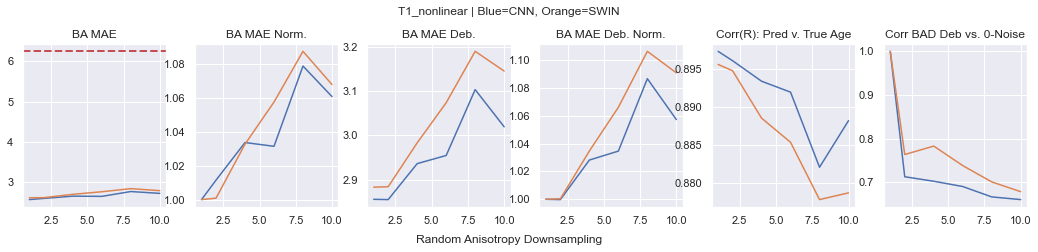

In [20]:
for idx in range(len(df1)):
    mod = str(df1.modality[idx])
    cnn = np.array([np.abs(df1.iloc[idx].dataframe.age_delta_1).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_2).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_3).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_4).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_5).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_6).mean(),
 
                   ])
    swin = np.array([np.abs(df2.iloc[idx].dataframe.age_delta_1).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_2).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_3).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_4).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_5).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_6).mean(),
 
                    ])
#     pearsonr
    fig, axs = plt.subplots(1,6,figsize=(18,3), facecolor='white')
    axs = axs.flatten()
    
    axs[0].plot(noiseSTD, cnn)
    axs[0].axhline(y=6.253, color='r', linestyle='dashed', label='Mean Age\nFailure Case', linewidth=2)
    axs[0].plot(noiseSTD, swin)
    axs[0].set_title('BA MAE')
    
    axs[1].plot(noiseSTD, cnn/cnn[0])
    axs[1].plot(noiseSTD, swin/swin[0])  
    axs[1].set_title('BA MAE Norm.')
    
    cnn = np.array([np.abs(df1.iloc[idx].dataframe.age_delta_decon_1).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_2).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_3).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_4).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_5).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_6).mean(),
 
                   ])
    swin = np.array([np.abs(df2.iloc[idx].dataframe.age_delta_decon_1).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_2).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_3).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_4).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_5).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_6).mean(),
  
                    ])
    
    axs[2].plot(noiseSTD, cnn)
    axs[2].plot(noiseSTD, swin)
    axs[2].set_title('BA MAE Deb.')
    
    axs[3].plot(noiseSTD, cnn/cnn[0])
    axs[3].plot(noiseSTD, swin/swin[0]) 
    axs[3].set_title('BA MAE Deb. Norm.')
    
    cnn = np.array([pearsonr(df1.iloc[idx].dataframe.output_age_1, df1.iloc[idx].dataframe.target_age), 
        pearsonr(df1.iloc[idx].dataframe.output_age_2, df1.iloc[idx].dataframe.target_age),
        pearsonr(df1.iloc[idx].dataframe.output_age_3, df1.iloc[idx].dataframe.target_age),
        pearsonr(df1.iloc[idx].dataframe.output_age_4, df1.iloc[idx].dataframe.target_age),
        pearsonr(df1.iloc[idx].dataframe.output_age_5, df1.iloc[idx].dataframe.target_age),
        pearsonr(df1.iloc[idx].dataframe.output_age_6, df1.iloc[idx].dataframe.target_age),

                   ])
    swin = np.array([pearsonr(df2.iloc[idx].dataframe.output_age_1, df2.iloc[idx].dataframe.target_age), 
        pearsonr(df2.iloc[idx].dataframe.output_age_2, df2.iloc[idx].dataframe.target_age),
        pearsonr(df2.iloc[idx].dataframe.output_age_3, df2.iloc[idx].dataframe.target_age),
        pearsonr(df2.iloc[idx].dataframe.output_age_4, df2.iloc[idx].dataframe.target_age),
        pearsonr(df2.iloc[idx].dataframe.output_age_5, df2.iloc[idx].dataframe.target_age),
        pearsonr(df2.iloc[idx].dataframe.output_age_6, df2.iloc[idx].dataframe.target_age),

                   ])
    
#     pearsonr(dfs[idx].target_age, dfs[idx].mean_output_age)[0]
    
    axs[4].plot(noiseSTD, cnn[:,0])
    axs[4].plot(noiseSTD, swin[:,0]) 
    axs[4].set_title('Corr(R): Pred v. True Age')
    
    baseCNN = df1.iloc[idx].dataframe.age_delta_decon_1
    baseSWIN = df2.iloc[idx].dataframe.age_delta_decon_1
    
    cnn = np.array([pearsonr(df1.iloc[idx].dataframe.age_delta_decon_1, baseCNN), 
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_2, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_3, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_4, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_5, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_6, baseCNN),

                   ])
    swin = np.array([pearsonr(df2.iloc[idx].dataframe.age_delta_decon_1, baseSWIN), 
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_2, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_3, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_4, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_5, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_6, baseSWIN),

                   ])
    
    
    axs[5].plot(noiseSTD, cnn[:,0])
    axs[5].plot(noiseSTD, swin[:,0])  
    axs[5].set_title('Corr BAD Deb vs. 0-Noise')
    
    fig.suptitle(mod + ' | Blue=CNN, Orange=SWIN', y=1.05)
    fig.supxlabel('Random Anisotropy Downsampling', y=-0.05)

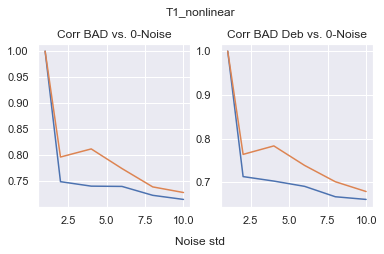

In [17]:


for idx in range(len(df1)):
    
    mod = df1.modality[idx]
    
    fig, axs = plt.subplots(1,2,figsize=(6,3))
    axs = axs.flatten()

    baseCNN = df1.iloc[idx].dataframe.age_delta_1
    baseSWIN = df2.iloc[idx].dataframe.age_delta_1
    
    cnn = np.array([pearsonr(df1.iloc[idx].dataframe.age_delta_1, baseCNN), 
        pearsonr(df1.iloc[idx].dataframe.age_delta_2, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_3, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_4, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_5, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_6, baseCNN),

                   ])
    swin = np.array([pearsonr(df2.iloc[idx].dataframe.age_delta_1, baseSWIN), 
        pearsonr(df2.iloc[idx].dataframe.age_delta_2, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_3, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_4, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_5, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_6, baseSWIN),
   
                   ])
    
    axs[0].plot(noiseSTD, cnn[:,0])
    axs[0].plot(noiseSTD, swin[:,0])
    axs[0].set_title('Corr BAD vs. 0-Noise')
    
    
    baseCNN = df1.iloc[idx].dataframe.age_delta_decon_1
    baseSWIN = df2.iloc[idx].dataframe.age_delta_decon_1
    
    cnn = np.array([pearsonr(df1.iloc[idx].dataframe.age_delta_decon_1, baseCNN), 
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_2, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_3, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_4, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_5, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_6, baseCNN),
      
                   ])
    swin = np.array([pearsonr(df2.iloc[idx].dataframe.age_delta_decon_1, baseSWIN), 
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_2, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_3, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_4, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_5, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_6, baseSWIN),

                   ])
    
    
    axs[1].plot(noiseSTD, cnn[:,0])
    axs[1].plot(noiseSTD, swin[:,0])  
    axs[1].set_title('Corr BAD Deb vs. 0-Noise')
    
    fig.suptitle(mod, y=1.05)
    fig.supxlabel('Noise std', y=-0.06)
    

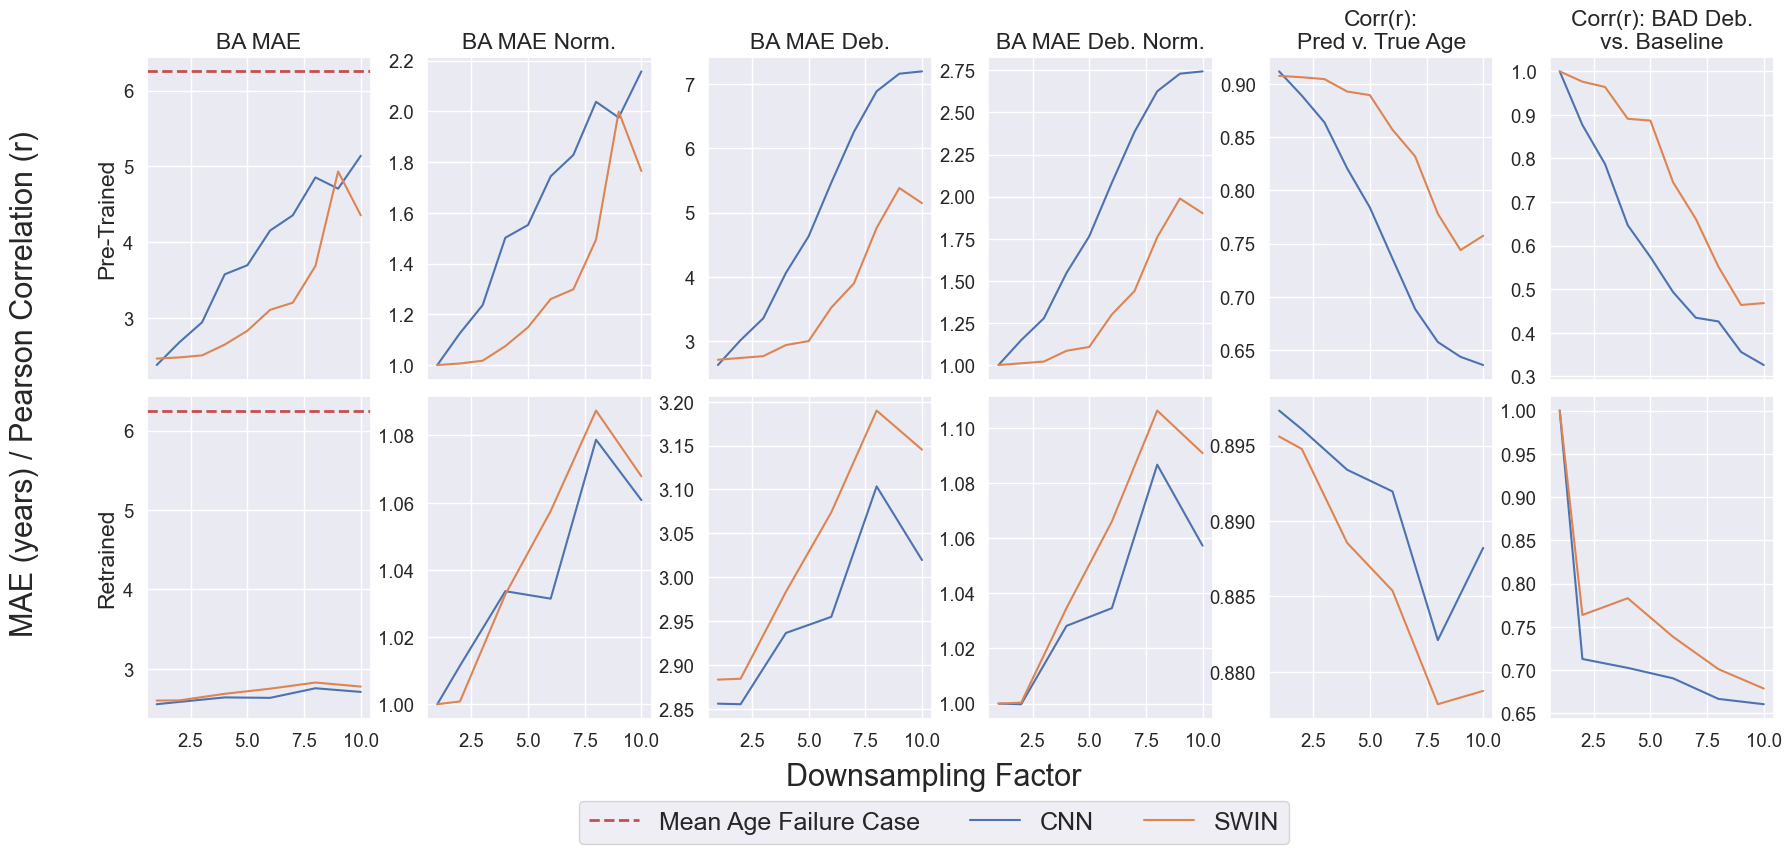

In [16]:
df1 = pd.read_pickle('female_test_testB_CNN_RandomAnisotroy.pkl')
df2 = pd.read_pickle('female_test_testB_SWIN_RandomAnisotropy.pkl')

noiseSTD = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

df1 = pd.concat([df1, pd.read_pickle('female_test_testB_CNN_RandomAnisotropy_retrain.pkl')])
df2 = pd.concat([df2, pd.read_pickle('female_test_testB_SWIN_RandomAnisotropy_retrain.pkl')])

noiseSTDr = [
    1,2,4,6,8,10
]

fig, axs = plt.subplots(2,6,figsize=(21,8.6), facecolor='white')
axs = axs.flatten()
names = ['Pre-Trained', 'Retrained']

axsIdx = 0

title_font_size=22
ticks_font_size=18
legend_font = 18


for idx in range(len(df1)):
#     mod = str(df1.modality[idx])
    
    if idx != 1:
    
        cnn = np.array([np.abs(df1.iloc[idx].dataframe.age_delta_1).mean(), 
            np.abs(df1.iloc[idx].dataframe.age_delta_2).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_3).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_4).mean(), 
            np.abs(df1.iloc[idx].dataframe.age_delta_5).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_6).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_7).mean(), 
            np.abs(df1.iloc[idx].dataframe.age_delta_8).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_9).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_10).mean(), 
#             np.abs(df1.iloc[idx].dataframe.age_delta_11).mean(),
#             np.abs(df1.iloc[idx].dataframe.age_delta_12).mean()
                       ])
        swin = np.array([np.abs(df2.iloc[idx].dataframe.age_delta_1).mean(), 
            np.abs(df2.iloc[idx].dataframe.age_delta_2).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_3).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_4).mean(), 
            np.abs(df2.iloc[idx].dataframe.age_delta_5).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_6).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_7).mean(), 
            np.abs(df2.iloc[idx].dataframe.age_delta_8).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_9).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_10).mean(), 
#             np.abs(df2.iloc[idx].dataframe.age_delta_11).mean(),
#             np.abs(df2.iloc[idx].dataframe.age_delta_12).mean()
                        ])
        
        axs[axsIdx].plot(noiseSTD, cnn)
        axs[axsIdx].plot(noiseSTD, swin)
        
    else:
        
        cnn = np.array([np.abs(df1.iloc[idx].dataframe.age_delta_1).mean(), 
            np.abs(df1.iloc[idx].dataframe.age_delta_2).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_3).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_4).mean(), 
            np.abs(df1.iloc[idx].dataframe.age_delta_5).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_6).mean()])
        swin = np.array([np.abs(df2.iloc[idx].dataframe.age_delta_1).mean(), 
            np.abs(df2.iloc[idx].dataframe.age_delta_2).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_3).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_4).mean(), 
            np.abs(df2.iloc[idx].dataframe.age_delta_5).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_6).mean()])
        
        axs[axsIdx].plot(noiseSTDr, cnn)
        axs[axsIdx].plot(noiseSTDr, swin)

    
    
    if idx==1:
        axs[axsIdx].axhline(y=6.253, color='r', linestyle='dashed', label='Mean Age Failure Case', linewidth=2)
    else:
        axs[axsIdx].axhline(y=6.253, color='r', linestyle='dashed', linewidth=2)
    
    factor = 0.75
    axs[axsIdx].set_ylabel(names[idx], fontsize=title_font_size*factor)
    
    if idx != 1:
        axs[axsIdx+1].plot(noiseSTD, cnn/cnn[0])
        axs[axsIdx+1].plot(noiseSTD, swin/swin[0])  
    else:
        axs[axsIdx+1].plot(noiseSTDr, cnn/cnn[0])
        axs[axsIdx+1].plot(noiseSTDr, swin/swin[0])  
    
    if idx != 1 :
        cnn = np.array([np.abs(df1.iloc[idx].dataframe.age_delta_decon_1).mean(), 
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_2).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_3).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_4).mean(), 
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_5).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_6).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_7).mean(), 
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_8).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_9).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_10).mean(), 
#             np.abs(df1.iloc[idx].dataframe.age_delta_decon_11).mean(),
#             np.abs(df1.iloc[idx].dataframe.age_delta_decon_12).mean()
                       ])
        swin = np.array([np.abs(df2.iloc[idx].dataframe.age_delta_decon_1).mean(), 
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_2).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_3).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_4).mean(), 
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_5).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_6).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_7).mean(), 
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_8).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_9).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_10).mean(), 
#             np.abs(df2.iloc[idx].dataframe.age_delta_decon_11).mean(),
#             np.abs(df2.iloc[idx].dataframe.age_delta_decon_12).mean()
                        ])
        
        axs[axsIdx+2].plot(noiseSTD, cnn)
        axs[axsIdx+2].plot(noiseSTD, swin)


        axs[axsIdx+3].plot(noiseSTD, cnn/cnn[0])
        axs[axsIdx+3].plot(noiseSTD, swin/swin[0]) 
    else:
        cnn = np.array([np.abs(df1.iloc[idx].dataframe.age_delta_decon_1).mean(), 
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_2).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_3).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_4).mean(), 
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_5).mean(),
            np.abs(df1.iloc[idx].dataframe.age_delta_decon_6).mean()])
        swin = np.array([np.abs(df2.iloc[idx].dataframe.age_delta_decon_1).mean(), 
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_2).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_3).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_4).mean(), 
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_5).mean(),
            np.abs(df2.iloc[idx].dataframe.age_delta_decon_6).mean()])
        
        axs[axsIdx+2].plot(noiseSTDr, cnn)
        axs[axsIdx+2].plot(noiseSTDr, swin)


        axs[axsIdx+3].plot(noiseSTDr, cnn/cnn[0])
        axs[axsIdx+3].plot(noiseSTDr, swin/swin[0]) 
    
    
    
    if idx != 1:
        cnn = np.array([pearsonr(df1.iloc[idx].dataframe.output_age_1, df1.iloc[idx].dataframe.target_age), 
            pearsonr(df1.iloc[idx].dataframe.output_age_2, df1.iloc[idx].dataframe.target_age),
            pearsonr(df1.iloc[idx].dataframe.output_age_3, df1.iloc[idx].dataframe.target_age),
            pearsonr(df1.iloc[idx].dataframe.output_age_4, df1.iloc[idx].dataframe.target_age),
            pearsonr(df1.iloc[idx].dataframe.output_age_5, df1.iloc[idx].dataframe.target_age),
            pearsonr(df1.iloc[idx].dataframe.output_age_6, df1.iloc[idx].dataframe.target_age),
            pearsonr(df1.iloc[idx].dataframe.output_age_7, df1.iloc[idx].dataframe.target_age),
            pearsonr(df1.iloc[idx].dataframe.output_age_8, df1.iloc[idx].dataframe.target_age),
            pearsonr(df1.iloc[idx].dataframe.output_age_9, df1.iloc[idx].dataframe.target_age),
            pearsonr(df1.iloc[idx].dataframe.output_age_10, df1.iloc[idx].dataframe.target_age),
#             pearsonr(df1.iloc[idx].dataframe.output_age_11, df1.iloc[idx].dataframe.target_age),
#             pearsonr(df1.iloc[idx].dataframe.output_age_12, df1.iloc[idx].dataframe.target_age),
                       ])
        swin = np.array([pearsonr(df2.iloc[idx].dataframe.output_age_1, df2.iloc[idx].dataframe.target_age), 
            pearsonr(df2.iloc[idx].dataframe.output_age_2, df2.iloc[idx].dataframe.target_age),
            pearsonr(df2.iloc[idx].dataframe.output_age_3, df2.iloc[idx].dataframe.target_age),
            pearsonr(df2.iloc[idx].dataframe.output_age_4, df2.iloc[idx].dataframe.target_age),
            pearsonr(df2.iloc[idx].dataframe.output_age_5, df2.iloc[idx].dataframe.target_age),
            pearsonr(df2.iloc[idx].dataframe.output_age_6, df2.iloc[idx].dataframe.target_age),
            pearsonr(df2.iloc[idx].dataframe.output_age_7, df2.iloc[idx].dataframe.target_age),
            pearsonr(df2.iloc[idx].dataframe.output_age_8, df2.iloc[idx].dataframe.target_age),
            pearsonr(df2.iloc[idx].dataframe.output_age_9, df2.iloc[idx].dataframe.target_age),
            pearsonr(df2.iloc[idx].dataframe.output_age_10, df2.iloc[idx].dataframe.target_age),
#             pearsonr(df2.iloc[idx].dataframe.output_age_11, df2.iloc[idx].dataframe.target_age),
#             pearsonr(df2.iloc[idx].dataframe.output_age_12, df2.iloc[idx].dataframe.target_age),
                       ])
        
        axs[axsIdx+4].plot(noiseSTD, cnn[:,0])
        axs[axsIdx+4].plot(noiseSTD, swin[:,0]) 
        
    else:
        cnn = np.array([pearsonr(df1.iloc[idx].dataframe.output_age_1, df1.iloc[idx].dataframe.target_age), 
            pearsonr(df1.iloc[idx].dataframe.output_age_2, df1.iloc[idx].dataframe.target_age),
            pearsonr(df1.iloc[idx].dataframe.output_age_3, df1.iloc[idx].dataframe.target_age),
            pearsonr(df1.iloc[idx].dataframe.output_age_4, df1.iloc[idx].dataframe.target_age),
            pearsonr(df1.iloc[idx].dataframe.output_age_5, df1.iloc[idx].dataframe.target_age),
            pearsonr(df1.iloc[idx].dataframe.output_age_6, df1.iloc[idx].dataframe.target_age),

                       ])
        swin = np.array([pearsonr(df2.iloc[idx].dataframe.output_age_1, df2.iloc[idx].dataframe.target_age), 
            pearsonr(df2.iloc[idx].dataframe.output_age_2, df2.iloc[idx].dataframe.target_age),
            pearsonr(df2.iloc[idx].dataframe.output_age_3, df2.iloc[idx].dataframe.target_age),
            pearsonr(df2.iloc[idx].dataframe.output_age_4, df2.iloc[idx].dataframe.target_age),
            pearsonr(df2.iloc[idx].dataframe.output_age_5, df2.iloc[idx].dataframe.target_age),
            pearsonr(df2.iloc[idx].dataframe.output_age_6, df2.iloc[idx].dataframe.target_age),

                   ])
        axs[axsIdx+4].plot(noiseSTDr, cnn[:,0])
        axs[axsIdx+4].plot(noiseSTDr, swin[:,0]) 
    
        
    
    
    baseCNN = df1.iloc[idx].dataframe.age_delta_decon_1
    baseSWIN = df2.iloc[idx].dataframe.age_delta_decon_1
    
    if idx !=1:
        cnn = np.array([pearsonr(df1.iloc[idx].dataframe.age_delta_decon_1, baseCNN), 
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_2, baseCNN),
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_3, baseCNN),
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_4, baseCNN),
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_5, baseCNN),
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_6, baseCNN),
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_7, baseCNN),
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_8, baseCNN),
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_9, baseCNN),
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_10, baseCNN),
#             pearsonr(df1.iloc[idx].dataframe.age_delta_decon_11, baseCNN),
#             pearsonr(df1.iloc[idx].dataframe.age_delta_decon_12, baseCNN),
                       ])
        swin = np.array([pearsonr(df2.iloc[idx].dataframe.age_delta_decon_1, baseSWIN), 
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_2, baseSWIN),
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_3, baseSWIN),
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_4, baseSWIN),
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_5, baseSWIN),
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_6, baseSWIN),
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_7, baseSWIN),
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_8, baseSWIN),
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_9, baseSWIN),
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_10, baseSWIN),
#             pearsonr(df2.iloc[idx].dataframe.age_delta_decon_11, baseSWIN),
#             pearsonr(df2.iloc[idx].dataframe.age_delta_decon_12, baseSWIN),
                       ])
    else:
        cnn = np.array([pearsonr(df1.iloc[idx].dataframe.age_delta_decon_1, baseCNN), 
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_2, baseCNN),
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_3, baseCNN),
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_4, baseCNN),
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_5, baseCNN),
            pearsonr(df1.iloc[idx].dataframe.age_delta_decon_6, baseCNN),

                       ])
        swin = np.array([pearsonr(df2.iloc[idx].dataframe.age_delta_decon_1, baseSWIN), 
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_2, baseSWIN),
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_3, baseSWIN),
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_4, baseSWIN),
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_5, baseSWIN),
            pearsonr(df2.iloc[idx].dataframe.age_delta_decon_6, baseSWIN),

                       ])
    
    if idx == 1:
        axs[axsIdx+5].plot(noiseSTDr, cnn[:,0], label='CNN')
        axs[axsIdx+5].plot(noiseSTDr, swin[:,0], label='SWIN')  
    else:
        axs[axsIdx+5].plot(noiseSTD, cnn[:,0])
        axs[axsIdx+5].plot(noiseSTD, swin[:,0])  
    
    if idx == 0:
        factor = 0.75
        axs[axsIdx].set_title('BA MAE', fontsize=title_font_size*factor)
        axs[axsIdx+1].set_title('BA MAE Norm.', fontsize=title_font_size*factor)
        axs[axsIdx+2].set_title('BA MAE Deb.', fontsize=title_font_size*factor)
        axs[axsIdx+3].set_title('BA MAE Deb. Norm.', fontsize=title_font_size*factor)
        axs[axsIdx+4].set_title('Corr(r):\nPred v. True Age', fontsize=title_font_size*factor)
        axs[axsIdx+5].set_title('Corr(r): BAD Deb.\nvs. Baseline', fontsize=title_font_size*factor)
        
    if idx != 1:
        axs[axsIdx].axes.xaxis.set_ticklabels([])
        axs[axsIdx+1].axes.xaxis.set_ticklabels([])
        axs[axsIdx+2].axes.xaxis.set_ticklabels([])
        axs[axsIdx+3].axes.xaxis.set_ticklabels([])
        axs[axsIdx+4].axes.xaxis.set_ticklabels([])
        axs[axsIdx+5].axes.xaxis.set_ticklabels([])
        
    factor = 0.74
        
    axs[axsIdx].tick_params(axis='both', labelsize=ticks_font_size*factor)
    axs[axsIdx+1].tick_params(axis='both', labelsize=ticks_font_size*factor)
    axs[axsIdx+2].tick_params(axis='both', labelsize=ticks_font_size*factor)
    axs[axsIdx+3].tick_params(axis='both', labelsize=ticks_font_size*factor)
    axs[axsIdx+4].tick_params(axis='both', labelsize=ticks_font_size*factor)
    axs[axsIdx+5].tick_params(axis='both', labelsize=ticks_font_size*factor)
    
    axsIdx += 6

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), fontsize=legend_font)
fig.supxlabel('Downsampling Factor', y=0.06, fontsize=title_font_size, verticalalignment='top')
fig.supylabel('MAE (years) / Pearson Correlation (r)', x= 0.06, fontsize=title_font_size, verticalalignment='center')
fig.subplots_adjust(wspace=0.25, hspace=0.05)

fig.savefig('CNNvsSWINvAnisotropyT1.png', bbox_inches='tight', facecolor='white')
